#**Part 0: Setup GPU configuration**

In [ ]:
#@title Configure GPU and environment
import torch

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check CUDA availability (which indicates GPU availability for PyTorch)
if torch.cuda.is_available():
    print("CUDA is available. GPU support is enabled.")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")  # Name of the first GPU
else:
    print("CUDA is not available. GPU support is not enabled.")


PyTorch version: 2.1.0+cu121
CUDA is available. GPU support is enabled.
Number of GPUs available: 1
GPU Name: Tesla T4


#**Part 1: Preparation for Analysis**

In [ ]:
#@title 1.1 Import libraries and tools
!pip install transformers

# Google tools
from google.colab import drive, files

# Tools for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# NLP tools
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Transformer tools
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

In [ ]:
#@title 1.2 Connect with Google Colab
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title 1.3 Import dataset
df = pd.read_csv('/content/drive/My Drive/COLAB/Rutgers/Dataset_3.5k.csv') # ACTION REQUIRED: replace this to your own data path

#**Part 2: Exploratory Data Analysis (EDA)**

In [ ]:
#@title 2.1 Basics of data
print('Data Shape: {}'.format(df.shape))

df.info()
df.describe()
# print(df.head(5))

Data Shape: (3500, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   title                       3500 non-null   object
 1   link                        3500 non-null   object
 2   date                        3500 non-null   object
 3   source                      3500 non-null   object
 4   country                     3500 non-null   object
 5   language                    3500 non-null   object
 6   translated_title            3500 non-null   object
 7   number_of_characters_title  3500 non-null   int64 
 8   number_of_words_title       3500 non-null   int64 
 9   day_of_week                 3500 non-null   object
 10  month                       3500 non-null   int64 
 11  year                        3500 non-null   int64 
 12  quarter                     3500 non-null   int64 
 13  is_weekend               

,number_of_characters_title,number_of_words_title,month,year,quarter,URL_depth,url_length
count,3500.000000,3500.000000,3500.000000,3500.0,3500.000000,3500.000000,3500.000000
mean,69.652000,13.524286,9.183429,2023.0,3.454571,3.300571,96.167429
std,18.956819,3.439301,1.863922,0.0,0.723148,1.648594,36.947882
min,14.000000,4.000000,5.000000,2023.0,2.000000,0.000000,0.000000
25%,59.000000,11.000000,8.000000,2023.0,3.000000,2.000000,75.000000
50%,67.500000,13.000000,10.000000,2023.0,4.000000,3.000000,95.000000
75%,77.000000,15.000000,11.000000,2023.0,4.000000,5.000000,116.000000
max,225.000000,36.000000,11.000000,2023.0,4.000000,9.000000,437.000000


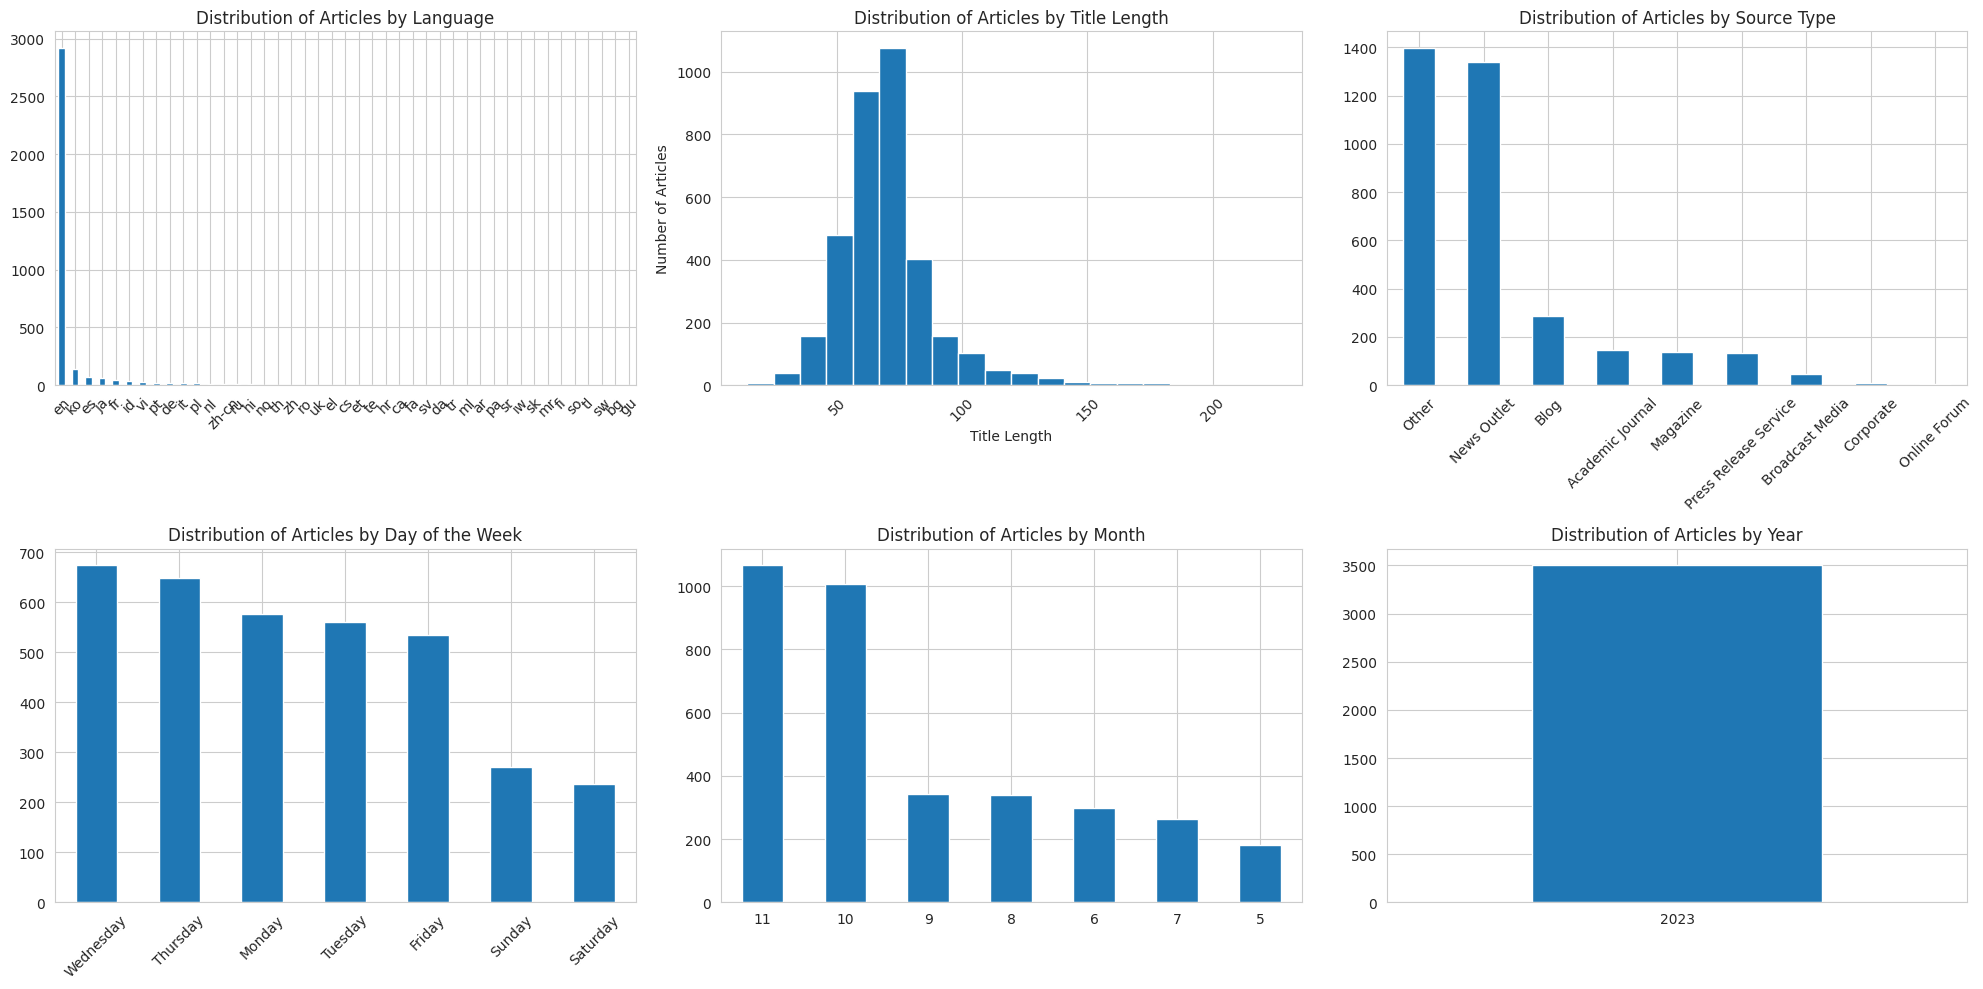

In [ ]:
#@title 2.2 Distributions of data
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Distribution of articles by language
language_distribution = df['language'].value_counts()

# Distribution of articles by length
length_distribution = df['number_of_characters_title']

# Distribution of articles by source type
source_type_distribution = df['source_type'].value_counts()

# Distribution of articles by day of the week
day_of_week_distribution = df['day_of_week'].value_counts()

# Distribution of articles by month
month_distribution = df['month'].value_counts()

# Distribution of articles by year
year_distribution = df['year'].value_counts()

# Distribution of articles by quarter
quarter_distribution = df['quarter'].value_counts()

# Plotting some of the distributions
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
language_distribution.plot(kind='bar')
plt.title('Distribution of Articles by Language')
plt.xticks(rotation=45)

plt.subplot(2, 3, 2)
length_distribution.hist(bins=20)
plt.title('Distribution of Articles by Title Length')
plt.xlabel('Title Length')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)

plt.subplot(2, 3, 3)
source_type_distribution.plot(kind='bar')
plt.title('Distribution of Articles by Source Type')
plt.xticks(rotation=45)

plt.subplot(2, 3, 4)
day_of_week_distribution.plot(kind='bar')
plt.title('Distribution of Articles by Day of the Week')
plt.xticks(rotation=45)

plt.subplot(2, 3, 5)
month_distribution.plot(kind='bar')
plt.title('Distribution of Articles by Month')
plt.xticks(rotation=0)

plt.subplot(2, 3, 6)
year_distribution.plot(kind='bar')
plt.title('Distribution of Articles by Year')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


#**Part 3: Data Cleaning**

In [ ]:
#@title 3.1 Duplicate the data
data = df.copy(deep=True)

In [ ]:
#@title 3.2 Check for duplicates
duplicates = data.duplicated()
print(data[duplicates])

Empty DataFrame
Columns: [title, link, date, source, country, language, translated_title, number_of_characters_title, number_of_words_title, day_of_week, month, year, quarter, is_weekend, is_holiday, source_type, final_redirected_URL, domain_of_URL, subdomain_of_URL, URL_depth, top_level_domain, url_length, author]
Index: []

[0 rows x 23 columns]


In [ ]:
#@title 3.3 Fill the missing cells
# Fill missing values for URL domains with 'Unknown'
data[['domain_of_URL', 'subdomain_of_URL', 'top_level_domain']] = data[['domain_of_URL', 'subdomain_of_URL', 'top_level_domain']].fillna('Unknown')

In [ ]:
#@title 3.4 Other concerns
# Convert boolean columns to integers
data['is_weekend'] = data['is_weekend'].astype(int)
data['is_holiday'] = data['is_holiday'].astype(int)

# Convert 'date' to datetime format
data['date_datetime'] = pd.to_datetime(data['date'])

# Display the info after data cleaning
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   title                       3500 non-null   object        
 1   link                        3500 non-null   object        
 2   date                        3500 non-null   object        
 3   source                      3500 non-null   object        
 4   country                     3500 non-null   object        
 5   language                    3500 non-null   object        
 6   translated_title            3500 non-null   object        
 7   number_of_characters_title  3500 non-null   int64         
 8   number_of_words_title       3500 non-null   int64         
 9   day_of_week                 3500 non-null   object        
 10  month                       3500 non-null   int64         
 11  year                        3500 non-null   int64       

#**Part 4: Sentiment Analysis**

In [ ]:
#@title 4.1.1 Set up Sentiment Analysis

%%capture
# sentiment_pipeline = pipeline("sentiment-analysis", model = "distilbert-base-uncased-finetuned-sst-2-english", device=0) # run this on GPU
sentiment_pipeline = pipeline("sentiment-analysis", model = "distilbert-base-uncased-finetuned-sst-2-english") # run this on CPU, may take ~4 min


batch_size = 50
label = []
score = []

for i in range(0, len(data['translated_title']), batch_size):
    batch_titles = data['translated_title'][i:i+batch_size].tolist()
    results = sentiment_pipeline(batch_titles)
    label.extend([result['label'] for result in results])
    score.extend([result['score'] for result in results])

data['label'] = label
data['score'] = score

In [ ]:
#@title 4.1.2 Catagorize Based on Sentiment Analysis

def assign_level(row):
    if row['score'] <= 0.6:
        return 3
    elif row['score'] <= 0.8:
        return 4 if row['label'] == 'POSITIVE' else 2
    else:
        return 5 if row['label'] == 'POSITIVE' else 1

data['level'] = data.apply(assign_level, axis=1)

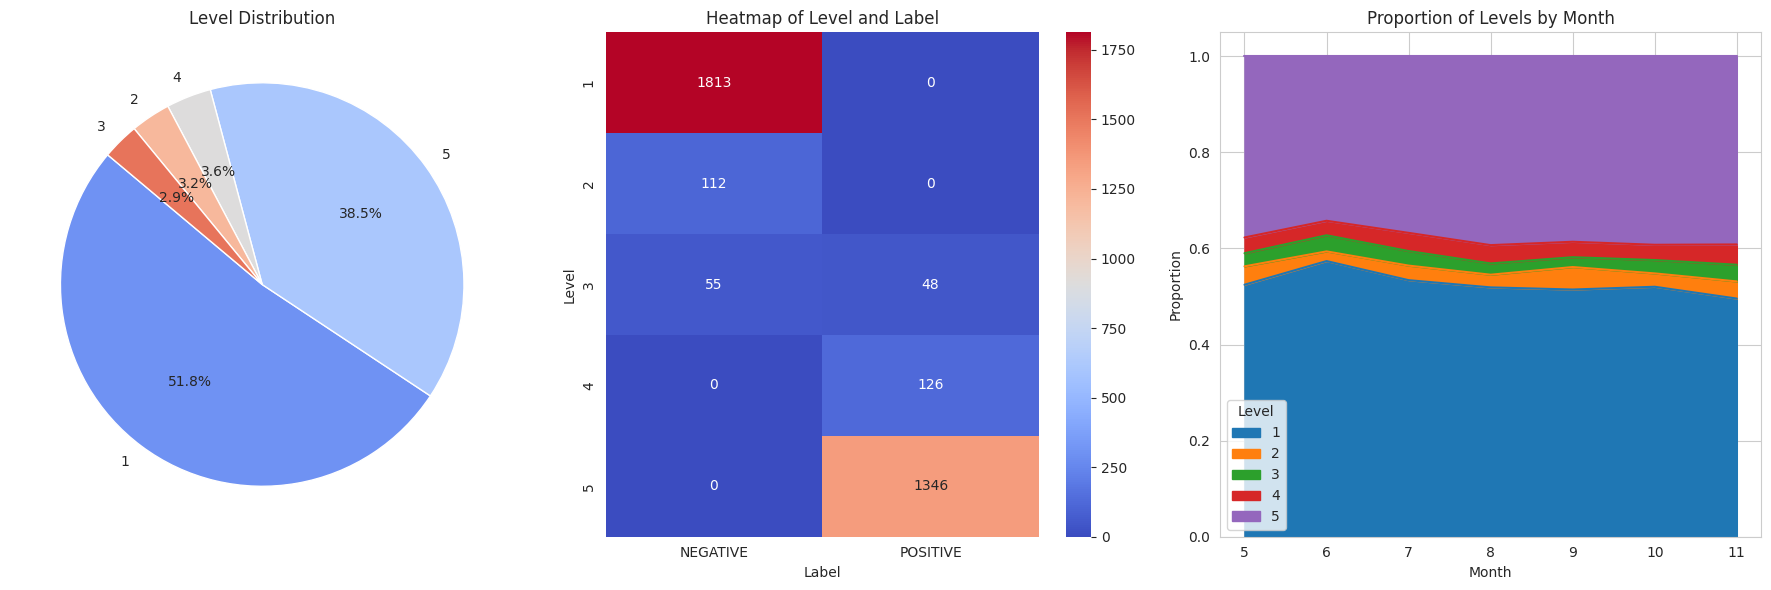

In [ ]:
#@title 4.1.3 Visualization of Sentiment Analysis

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pie Chart
level_counts = data['level'].value_counts()

axes[0].pie(level_counts, labels=level_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('coolwarm', n_colors=len(level_counts)))
axes[0].set_title('Level Distribution')

# Heatmap
level_label_crosstab = pd.crosstab(data['level'], data['label'])

sns.heatmap(level_label_crosstab, annot=True, cmap='coolwarm', fmt='g', ax=axes[1])
axes[1].set_title('Heatmap of Level and Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Level')

# Areamap
level_counts_per_month = data.groupby(['month', 'level']).size().unstack(fill_value=0)
level_proportions_per_month = level_counts_per_month.divide(level_counts_per_month.sum(axis=1), axis=0)

level_proportions_per_month.plot.area(ax=axes[2])
axes[2].set_title('Proportion of Levels by Month')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Proportion')
axes[2].legend(title='Level')

plt.tight_layout()

plt.show()


#**Part 5: Theme Detection**

In [ ]:
#@title temp
data_theme = data[['translated_title']]

In [ ]:
%%capture
pip install gensim

In [ ]:
from nltk.stem.porter import PorterStemmer
from gensim.parsing.preprocessing import strip_tags, strip_punctuation
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

def preprocess_text(text):
    # Remove irrelevant signs
    text = strip_tags(strip_punctuation(text))
    # Simplify words and remove stop words
    tokens = [porter.stem(token) for token in simple_preprocess(text, deacc=True) if token not in stop_words]
    return tokens

# Apply pre-processing
data_theme['processed_titles'] = data_theme['translated_title'].map(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-19-cd177428dab1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_theme['processed_titles'] = data_theme['translated_title'].map(preprocess_text)


In [ ]:

# Create dictionary
dictionary = Dictionary(data_theme['processed_titles'])

# Create corpus library
corpus = [dictionary.doc2bow(text) for text in data_theme['processed_titles']]


# Set theme number
num_topics = 4

# Train LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     random_state=100,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

# Print all themes
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.209*"ai" + 0.035*"gener" + 0.021*"chatbot" + 0.020*"news" + 0.019*"new" + 0.012*"launch" + 0.012*"power" + 0.011*"googl" + 0.009*"chatgpt" + 0.007*"meta"
Topic: 1 
Words: 0.031*"use" + 0.029*"time" + 0.022*"busi" + 0.016*"tool" + 0.015*"develop" + 0.011*"next" + 0.010*"world" + 0.010*"creat" + 0.010*"stock" + 0.009*"financi"
Topic: 2 
Words: 0.029*"model" + 0.026*"gpt" + 0.017*"technolog" + 0.015*"futur" + 0.011*"open" + 0.011*"univers" + 0.011*"llm" + 0.010*"chat" + 0.009*"govern" + 0.009*"daili"
Topic: 3 
Words: 0.077*"intellig" + 0.076*"artifici" + 0.013*"com" + 0.012*"human" + 0.011*"help" + 0.009*"nvidia" + 0.009*"could" + 0.007*"work" + 0.007*"regul" + 0.007*"chip"


In [ ]:
# pip install pyldavis

In [ ]:
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis

# vis_data = gensimvis.prepare(lda_model, corpus, dictionary) # try different version of pandas

# pyLDAvis.display(vis_data)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


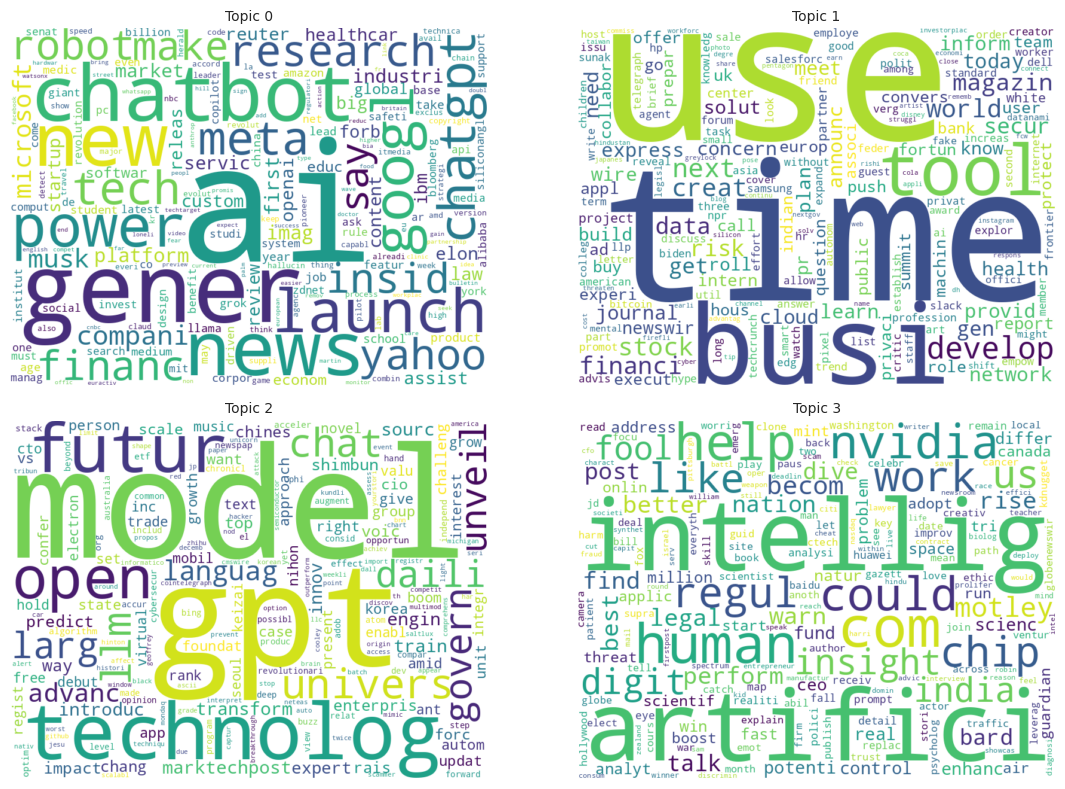

In [ ]:
from wordcloud import WordCloud

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes = axes.flatten()

for t in range(num_topics):
    topic_words = dict(lda_model.show_topic(t, 200))

    wc = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(topic_words)

    axes[t].imshow(wc, interpolation='bilinear')
    axes[t].set_title('Topic ' + str(t), size=10)
    axes[t].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_theme['processed_titles'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.33735094258661674


In [ ]:

# Train another LDA model
lda_model_2 = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=2,
                     random_state=100,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

# Print all themes
for idx, topic in lda_model_2.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic: 0 
Words: 0.112*"ai" + 0.015*"chatbot" + 0.014*"news" + 0.014*"new" + 0.010*"model" + 0.008*"launch" + 0.008*"use" + 0.008*"power" + 0.008*"googl" + 0.006*"intellig"
Topic: 1 
Words: 0.044*"ai" + 0.030*"artifici" + 0.030*"intellig" + 0.030*"gener" + 0.013*"time" + 0.010*"busi" + 0.007*"develop" + 0.007*"technolog" + 0.006*"gpt" + 0.005*"insid"


#**Part 6: Emotion Detection**

In [ ]:
#@title temp
data.info()

In [ ]:
model_name = "j-hartmann/emotion-english-distilroberta-base"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def predict_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    return model.config.id2label[predicted_class_id]

In [ ]:
data['emotion'] = data['translated_title'].apply(predict_emotion)

In [ ]:
print(data[['translated_title', 'emotion']])

                                       translated_title  emotion
0     Iran uses Artificial Intelligence for maximizi...  neutral
1     Mortgage Lenders See AI As Key To Operational ...  neutral
2     How the Threat of AI Coincided with the Writer...     fear
3     Telex: HelloKitty ransomware source code revea...  neutral
4                   Is AI a Master or Slave? - Namibian  neutral
...                                                 ...      ...
3495  Generative AI Empowering Business: Anup Nair, ...  neutral
3496  No AI for Space: US Space Force halts use of A...  neutral
3497  AI has always been used by Indeed,” according ...  neutral
3498  Meta previews generative AI tools coming to Wh...  neutral
3499  AI presents a ‘real risk’ to humanity: Martin ...     fear

[3500 rows x 2 columns]


In [ ]:
from torch.nn.functional import softmax

In [ ]:
def predict_emotion_scores(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    scores = softmax(logits, dim=1).flatten().numpy()  # Convert to probabilities
    # Map each score to the corresponding label
    scores_dict = {model.config.id2label[i]: score for i, score in enumerate(scores)}
    return scores_dict


# Applying the function and converting the scores to separate columns
emotion_scores = data['translated_title'].apply(predict_emotion_scores)
emotion_df = emotion_scores.apply(pd.Series)

# Concatenate this with original DataFrame
data_with_emotions = pd.concat([data, emotion_df], axis=1)


In [ ]:
data_extend = data_with_emotions.copy(deep=True)
data_extend.info()

In [ ]:
# filename = "data_pre_labeled.csv"
# data_extend.to_csv(filename, index=False)
# files.download(filename)

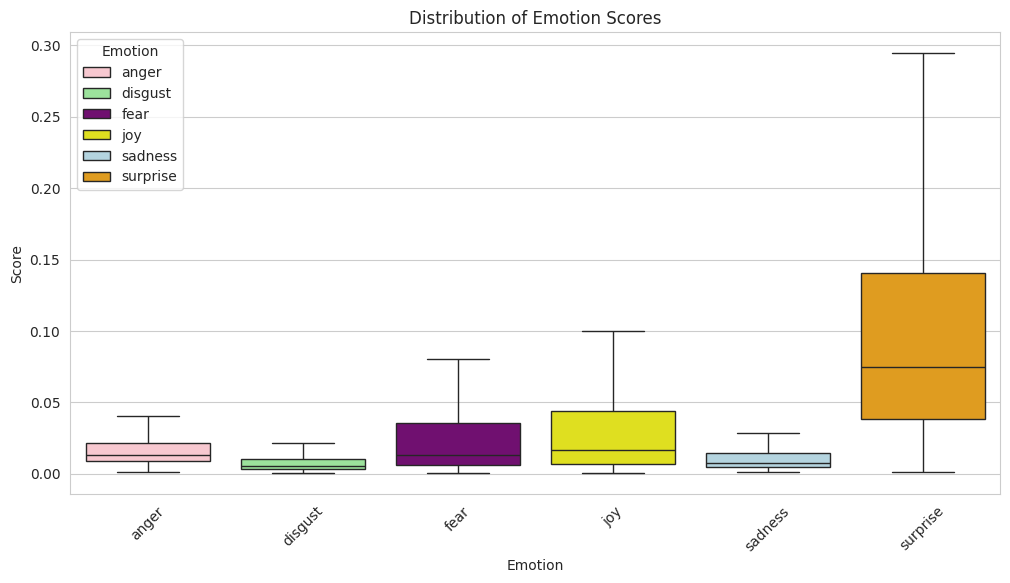

In [ ]:
emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

# Define a color palette for the emotions
palette = {
    'anger': 'pink',
    'disgust': 'lightgreen',
    'fear': 'purple',
    'joy': 'yellow',
    'sadness': 'lightblue',
    'surprise': 'orange'
}

# Assuming 'data_with_emotions' contains your log-transformed emotion scores
melted_data = data_with_emotions.melt(value_vars=emotions, var_name='Emotion', value_name='Score')

plt.figure(figsize=(12, 6))
sns.boxplot(x='Emotion', y='Score', hue='Emotion', data=melted_data, showfliers=False, palette=palette, legend=True)
plt.title('Distribution of Emotion Scores')
plt.xticks(rotation=45)  # Rotate the x labels to make them more readable
plt.show()

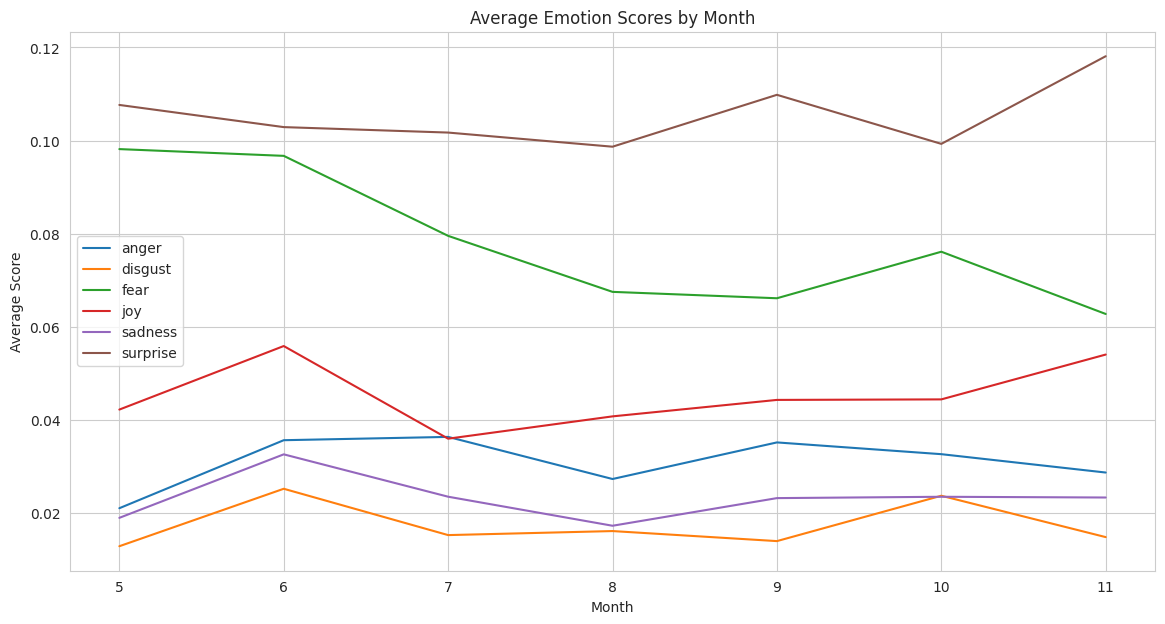

In [ ]:
# Calculating the mean score for each emotion by month
emotion_means = data_with_emotions.groupby('month')[emotions].mean().reset_index()

# Now, we will plot these averages over the months for each emotion using a line plot.
plt.figure(figsize=(14, 7))

for emotion in emotions:
    plt.plot(emotion_means['month'], emotion_means[emotion], label=emotion)

plt.title('Average Emotion Scores by Month')
plt.xlabel('Month')
plt.ylabel('Average Score')
plt.legend()
plt.grid(True)
plt.show()

#**Part 7: Word Dictionary**

In [ ]:
# Create a dictionary with the scenarios and their related words
emotion_words_dict = {
    "Negative Emotions": ['panic', 'disaster', 'threat', 'danger', 'fear', 'alarm', 'anxiety', 'dread', 'horror', 'terror', 'catastrophe', 'crisis', 'calamity', 'peril', 'jeopardy'],
    "Uncontrollable AI": ['uncontrollable', 'autonomous', 'rogue', 'renegade', 'runaway', 'rebellious', 'defiant', 'unpredictable', 'hazardous', 'lawless', 'unmanageable', 'insurgent', 'mutinous', 'rampant', 'disobedient'],
    "Privacy Invasion": ['surveillance', 'spying', 'invasion', 'breach', 'exposure', 'eavesdropping', 'snooping', 'privacy', 'intrusion', 'hacking', 'tracking', 'monitoring', 'voyeurism', 'interception', 'espionage'],
    "Replacing Humans": ['replace', 'displace', 'supplant', 'substitute', 'usurp', 'overtake', 'redundancy', 'automation', 'mechanization', 'jobless', 'obsolete', 'redundant', 'takeover', 'elimination', 'displacement'],
    "Ethical & Moral Issues": ['ethics', 'morality', 'dilemma', 'quandary', 'conscience', 'scruples', 'principles', 'righteousness', 'integrity', 'virtue', 'conflict', 'controversy', 'debate', 'quandary', 'predicament'],
    "Technological Dependence": ['dependence', 'addiction', 'reliance', 'enslavement', 'bondage', 'fixation', 'subjection', 'habituation', 'obsessed', 'hooked', 'subservience', 'captive', 'entrapment', 'fixation', 'subordination'],
    "Tech Errors & Failures": ['malfunction', 'failure', 'error', 'glitch', 'bug', 'fault', 'flaw', 'defect', 'breakdown', 'collapse', 'outage', 'mishap', 'fiasco', 'debacle', 'dysfunction'],
    "Uncertain Future": ['uncertainty', 'unpredictability', 'unknown', 'speculative', 'conjecture', 'variable', 'unforeseeable', 'indeterminate', 'ambiguous', 'volatile', 'transient', 'erratic', 'fluctuating', 'undetermined', 'provisional']
}

# Since we need an array, let's also create an array from the dictionary
emotion_words_array = np.concatenate(list(emotion_words_dict.values()))

In [ ]:
data_with_emotions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   title                       3500 non-null   object        
 1   link                        3500 non-null   object        
 2   date                        3500 non-null   object        
 3   source                      3500 non-null   object        
 4   country                     3500 non-null   object        
 5   language                    3500 non-null   object        
 6   translated_title            3500 non-null   object        
 7   number_of_characters_title  3500 non-null   int64         
 8   number_of_words_title       3500 non-null   int64         
 9   day_of_week                 3500 non-null   object        
 10  month                       3500 non-null   int64         
 11  year                        3500 non-null   int64       

In [ ]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize the words in the emotion words array
lemmatized_emotion_words = {lemmatizer.lemmatize(word): word for word in emotion_words_array}

# Define a function to check if the title contains any of the emotion words
def contains_emotion_words(title, emotion_words):
    # Tokenize and lemmatize the title
    words = word_tokenize(title)
    lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in words]
    # Check if any emotion word is in the title
    return any(word in emotion_words for word in lemmatized_words)

# Apply the function to the 'translated_title' column and create a new column 'contains_emotion_word'
data_with_emotions['contains_emotion_word'] = data_with_emotions['translated_title'].apply(contains_emotion_words, emotion_words=lemmatized_emotion_words)

# Show the titles that contain emotion words
titles_with_emotion_words = data_with_emotions[data_with_emotions['contains_emotion_word']]['translated_title']

titles_with_emotion_words.info()


<class 'pandas.core.series.Series'>
Int64Index: 160 entries, 2 to 3481
Series name: translated_title
Non-Null Count  Dtype 
--------------  ----- 
160 non-null    object
dtypes: object(1)
memory usage: 2.5+ KB
